In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.stats import pareto
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import warnings
warnings.filterwarnings('ignore')
import dateutil.relativedelta as relativedelta

plt.style.use('ggplot')
%matplotlib inline

In [2]:
timeseries = pd.read_csv('Consumo Gas Region Magallanes.csv', sep=';',encoding = 'ISO-8859-1')

In [3]:
timeseries.head()

,Consumo,Dia,Mes,Año,DiaSemana,Feriado
0,716,20,10,1995,Viernes,0
1,605,21,10,1995,Sábado,1
2,555,22,10,1995,Domingo,1
3,680,23,10,1995,Lunes,0
4,713,24,10,1995,Martes,0


In [4]:
consumo_anual = timeseries.groupby('Año').agg({'Consumo':sum})

In [5]:
base = consumo_anual[consumo_anual.index==1996].Consumo.values[0]

consumo_anual['total_base'] = base
consumo_anual['delta_consumo'] = (consumo_anual['Consumo']-consumo_anual['total_base'])
consumo_anual['porc_variacion'] =round((consumo_anual['delta_consumo'] / consumo_anual['total_base']) * 100, 2)

In [6]:
consumo_anual.porc_variacion.iloc[0] = 0
consumo_anual['Año'] = consumo_anual.index.astype('int64')

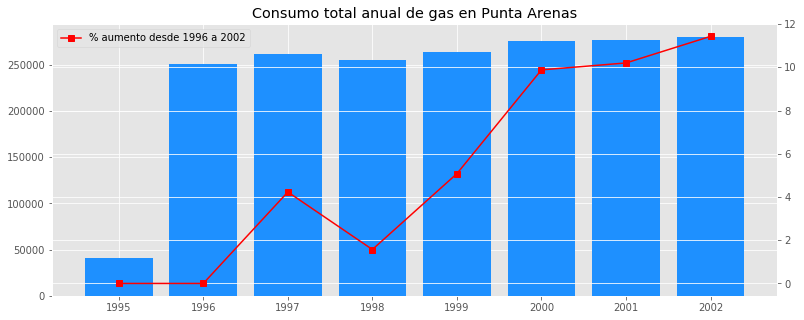

In [7]:
fig, ax1= plt.subplots(figsize=(13,5))

ax1.bar(consumo_anual.Año,consumo_anual['Consumo'],color='dodgerblue')

ax2 = ax1.twinx()

ax2.plot(consumo_anual.Año,consumo_anual['porc_variacion'],color='red', marker='s', label = '% aumento desde 1996 a 2002')

plt.title('Consumo total anual de gas en Punta Arenas')
plt.legend()
plt.show()

In [8]:
consumo_anual

,Consumo,total_base,delta_consumo,porc_variacion,Año
Año,,,,,
1995,40526,251580,-211054,0.00,1995
1996,251580,251580,0,0.00,1996
1997,262226,251580,10646,4.23,1997
1998,255529,251580,3949,1.57,1998
1999,264356,251580,12776,5.08,1999
2000,276434,251580,24854,9.88,2000
2001,277235,251580,25655,10.20,2001
2002,280345,251580,28765,11.43,2002


In [9]:
timeseries['date'] = timeseries.Año.map(str)+'-'+timeseries.Mes.map(str)+'-'+timeseries.Dia.map(str)
timeseries['date'] = pd.to_datetime(timeseries.date)

In [ ]:
timeseries.sort_values('date',ascending=False,inplace=True)
timeseries['week'] = 1

for i in range(0, timeseries.shape[0],7):
    timeseries.loc[timeseries.index[i:i+7], 'week'] = timeseries.loc[timeseries.index[i:i+7], 'date'].max()
    
consum_week = timeseries.groupby('week',as_index=False).agg({'Consumo':[sum,'count']})

consum_week.columns = ['_'.join(col).strip() for col in consum_week.columns.values]
consum_week.rename(columns={'week_':'week'},inplace=True)

consum_week = consum_week[consum_week['Consumo_count'] == 7]
consum_week = consum_week[['week','Consumo_sum']]

In [ ]:
timeseries['period_monthly'] = timeseries.date.dt.year*100 + timeseries.date.dt.month

timeseries = timeseries.sort_values('period_monthly')

consum_month = timeseries.groupby('period_monthly',as_index=False).agg({'date':min,'Consumo':sum})
consum_month = consum_month[consum_month.index != consum_month.index[0]]

In [ ]:
consum_week.rename(columns={'week':'periodo','Consumo_sum':'Consumo'},inplace=True)
consum_month.rename(columns={'date':'periodo'},inplace=True)

consum_week.to_csv('./consumo_semanal.csv',sep=';',index=False)
consum_month.to_csv('./consumo_mensual.csv',sep=';',index=False)

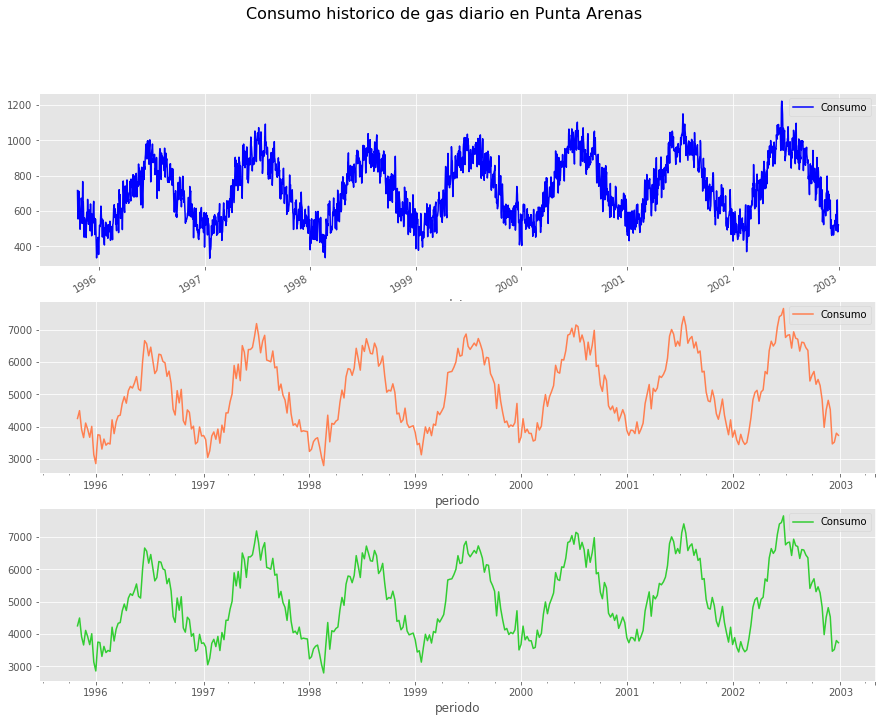

In [79]:
fig = plt.figure(figsize=(15, 12))

g1 = fig.add_subplot(311)
g2 = fig.add_subplot(312)
g3 = fig.add_subplot(313)

g1 = timeseries.plot(x='date',y='Consumo',color='blue', ax=g1)
g2 = consum_week.plot(x='periodo', y='Consumo', color='coral', ax=g2)
g3 = consum_week.plot(x='periodo', y='Consumo', color='limegreen', ax=g3)

fig.suptitle('Consumo historico de gas diario en Punta Arenas', fontsize=16)
plt.show()

In [ ]:
>>> fig = plt.figure(figsize=(8, 6))
>>> ax1 = fig.add_subplot(311)
>>> ax2 = fig.add_subplot(212)
>>> ax1.scatter(x1_data[0], y1_data[0]) 
>>> ax2.scatter(x2_data[0], y2_data[0])

In [11]:
timeseries['month'] = timeseries.Mes.apply(lambda x: calendar.month_abbr[x])

timeseries.sort_values('Mes',inplace=True)

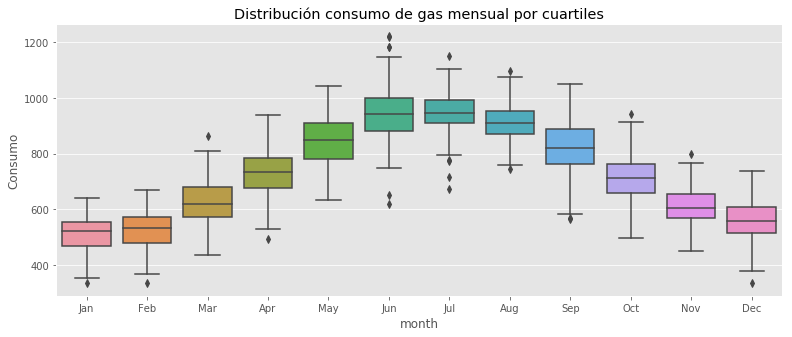

In [12]:
fig= plt.subplots(figsize=(13,5))

g = sns.boxplot(x='month',y='Consumo',data=timeseries)

plt.title('Distribución consumo de gas mensual por cuartiles')
plt.show()

In [13]:
consumo_mensual = timeseries.groupby('Mes',as_index=False).agg({'Consumo':['mean','std']})

consumo_mensual.columns = ['_'.join(col).strip() for col in consumo_mensual.columns.values]
consumo_mensual.rename(columns={'Mes_':'Mes'},inplace=True)
consumo_mensual['month'] = consumo_mensual.Mes.apply(lambda x: calendar.month_abbr[x])

consumo_mensual['Coeficiente_variacion'] = consumo_mensual.Consumo_std / consumo_mensual.Consumo_mean

In [14]:
consumo_mensual['pxmes'] = consumo_mensual.Consumo_mean.shift(1)

In [15]:
consumo_mensual['porc_variacion_mxm'] = (consumo_mensual.Consumo_mean - consumo_mensual.pxmes) / consumo_mensual.pxmes

In [16]:
consumo_mensual

,Mes,Consumo_mean,Consumo_std,month,Coeficiente_variacion,pxmes,porc_variacion_mxm
0,1,514.474654,59.912286,Jan,0.116453,NaN,NaN
1,2,527.914141,63.667503,Feb,0.120602,514.474654,0.026123
2,3,626.193548,83.691339,Mar,0.133651,527.914141,0.186166
3,4,729.552381,85.017474,Apr,0.116534,626.193548,0.165059
4,5,844.456221,85.293389,May,0.101004,729.552381,0.157499
5,6,938.919048,90.202261,Jun,0.096070,844.456221,0.111862
6,7,946.898618,72.129762,Jul,0.076175,938.919048,0.008499
7,8,910.156682,67.534719,Aug,0.074201,946.898618,-0.038802
8,9,819.009524,92.564783,Sep,0.113020,910.156682,-0.100144
9,10,709.864629,80.617812,Oct,0.113568,819.009524,-0.133265


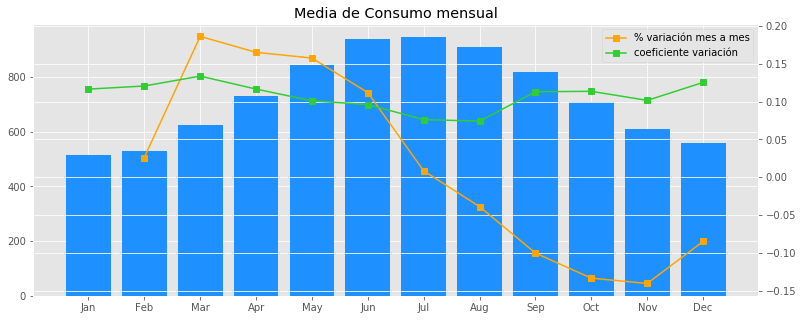

In [17]:
fig, ax1= plt.subplots(figsize=(13,5))

ax1.bar(consumo_mensual.month,consumo_mensual.Consumo_mean,color='dodgerblue')

ax2 = ax1.twinx()

ax2.plot(consumo_mensual.month,consumo_mensual['porc_variacion_mxm'],color='orange', marker='s', label="% variación mes a mes")
ax2.plot(consumo_mensual.month,consumo_mensual['Coeficiente_variacion'],color='limegreen', marker='s', label="coeficiente variación")
plt.legend()

plt.title('Media de Consumo mensual')
plt.show()

In [18]:
timeseries['estacion'] = np.where(timeseries['Mes'] <= 3,'Verano',np.where((timeseries['Mes'] >= 4) & (timeseries['Mes'] <= 6),'Otoño',np.where((timeseries['Mes'] >= 7) & (timeseries['Mes'] <= 9),'Invierno',np.where((timeseries['Mes'] >= 10) & (timeseries['Mes'] <= 12),'Primavera',None))))
timeseries.sort_values('Mes',inplace=True)

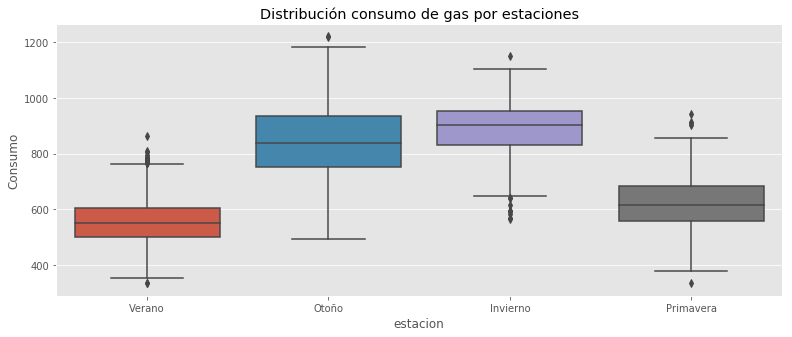

In [19]:
fig= plt.subplots(figsize=(13,5))

g = sns.boxplot(x='estacion',y='Consumo',data=timeseries)

plt.title('Distribución consumo de gas por estaciones')
plt.show()

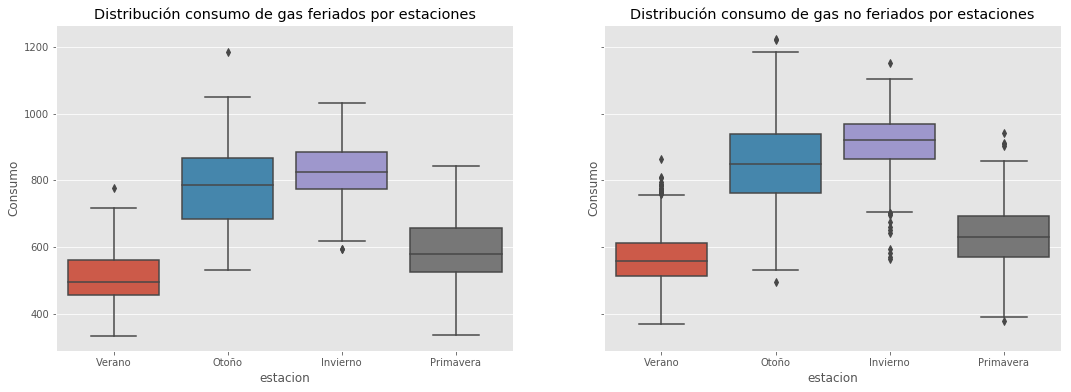

In [20]:
feriados = timeseries[timeseries['Feriado'] == 1]
feriados.sort_values('Mes',inplace=True)

no_feriados = timeseries[timeseries['Feriado'] == 0]
no_feriados.sort_values('Mes',inplace=True)

fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(18,6), sharey=True)

ax1 = sns.boxplot(x='estacion',y='Consumo',data=feriados, ax=ax1)
ax1.set_title('Distribución consumo de gas feriados por estaciones')

ax2 = sns.boxplot(x='estacion',y='Consumo',data=no_feriados, ax=ax2)
ax2.set_title('Distribución consumo de gas no feriados por estaciones')

plt.show()

In [21]:
timeseries['dias_sort'] = np.where(timeseries['DiaSemana'] == 'Lunes',1,np.where(timeseries['DiaSemana'] == 'Martes',2,np.where(timeseries['DiaSemana'] == 'Miércoles',3,np.where(timeseries['DiaSemana'] == 'Jueves',4,np.where(timeseries['DiaSemana'] == 'Viernes',5,np.where(timeseries['DiaSemana'] == 'Sábado',6,np.where(timeseries['DiaSemana'] == 'Domingo',7,0)))))))

timeseries.sort_values('dias_sort',inplace=True)

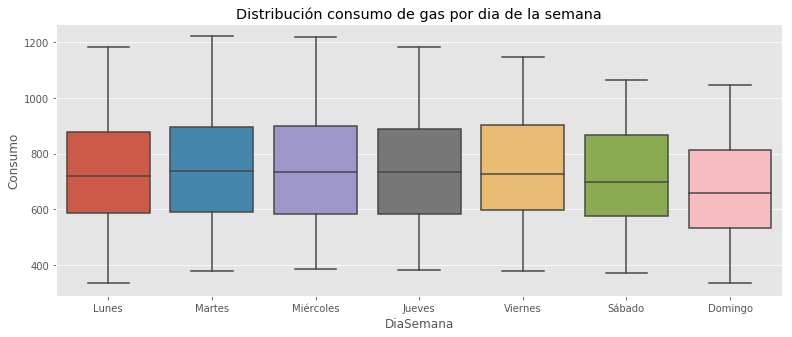

In [22]:
fig= plt.subplots(figsize=(13,5))

g = sns.boxplot(x='DiaSemana',y='Consumo',data=timeseries)

plt.title('Distribución consumo de gas por dia de la semana')
plt.show()

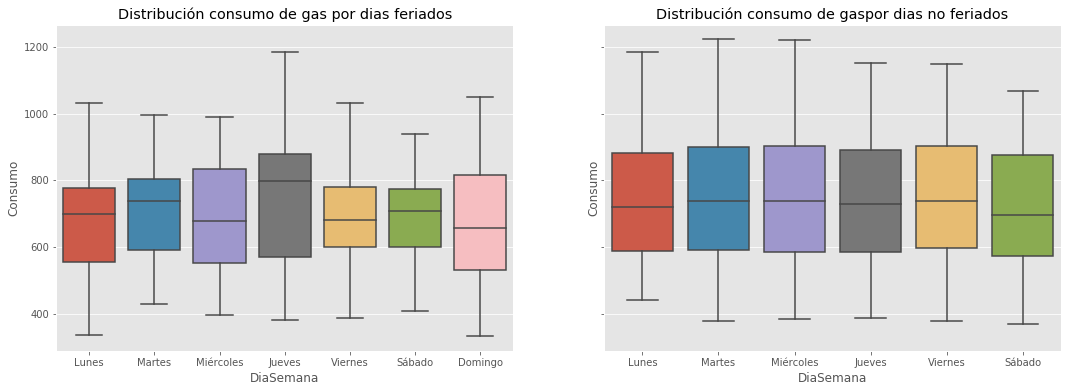

In [23]:
feriados = timeseries[timeseries['Feriado'] == 1]
feriados.sort_values('dias_sort',inplace=True)

no_feriados = timeseries[timeseries['Feriado'] == 0]
no_feriados.sort_values('dias_sort',inplace=True)

fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(18,6), sharey=True)

ax1 = sns.boxplot(x='DiaSemana',y='Consumo',data=feriados, ax=ax1)
ax1.set_title('Distribución consumo de gas por dias feriados')

ax2 = sns.boxplot(x='DiaSemana',y='Consumo',data=no_feriados, ax=ax2)
ax2.set_title('Distribución consumo de gaspor dias no feriados')

plt.show()

In [34]:
# setting temporary PATH variables
import os
os.environ['R_HOME'] = 'C:\Program Files\R\R-3.4.4' #path to your R installation
os.environ['R_USER'] = 'C:\Python36\Lib\site-packages\rpy2' #path depends on where you installed Pytho

In [35]:
import rpy2.rinterface

% load_ext rpy2.ipython

In [36]:
%%R -o forecast_days -o forecast_months -o forecast_weeks -o accuracy_days -o accuracy_months -o accuracy_weeks
#-o df_cv -o df_cv2 -o df_cv3

library(forecast)
library(RODBC)
library(prophet)
library(dplyr)

#######################################################################################
#                              Preparamos los datos                                   #
#######################################################################################

timeseries <- read.csv('Consumo Gas Region Magallanes.csv',sep=';')
paste(timeseries$Año,timeseries$Mes,timeseries$Dia, collapse="-")

timeseries$periodo <- apply( timeseries[ , c( 'Año' , 'Mes' , 'Dia' ) ] , 1 , paste , collapse = "-" )
timeseries$periodo <- as.Date(timeseries$periodo, "%Y-%m-%d")

# timeseries <- timeseries[timeseries$periodo >= '1996-01-01',]

#######################################################################################
#                              Datos por periodo semanal                              #
#######################################################################################

consumo_semanal <- read.csv('consumo_semanal.csv',sep=';')
consumo_semanal$periodo <- as.Date(consumo_semanal$periodo, "%Y-%m-%d")

#######################################################################################
#                           Datos por periodo mensual                                 #
#######################################################################################

consumo_mensual <- read.csv('consumo_mensual.csv',sep=';')
consumo_mensual$periodo <- as.Date(consumo_mensual$periodo, "%Y-%m-%d")

#######################################################################################
#                             Contemplamos los feriados                               #
#######################################################################################

feriados <- data_frame(
holiday = 'feriado',
ds = timeseries[timeseries$Feriado == 1,]$periodo,
lower_window = 0,
upper_window = 1)

holidays <- bind_rows(feriados)

#######################################################################################
#                             Entrenamiento y predicción                              #
#######################################################################################

##### Modelo por dias

timeseries <- timeseries[timeseries$periodo >= '1996-01-01',]

model <- prophet(data.frame(ds=timeseries$periodo, y=timeseries$Consumo), holidays = holidays,  
                 yearly.seasonality = TRUE, daily.seasonality = TRUE, weekly.seasonality = TRUE,n.changepoints = 21)
#model.add_seasonality(period=30.4, components=5, name='monthly')

futuro_days <- make_future_dataframe(model, periods = 7,freq = "days",include_history = FALSE)

forecast_days <- predict(model, futuro_days)
forecast_days <- forecast_days[,c('ds','yhat')]
colnames(forecast_days) <- c('periodo', 'prediccion_consumo')
forecast_days$prediccion_consumo <- as.integer(forecast_days$prediccion_consumo)
forecast_days$periodo <- as.character.Date(forecast_days$periodo)

# df_cv <- cross_validation(model, initial = 1170, period = 180, horizon = 365, units = 'days')
# head(df_cv)

# df_p <- performance_metrics(df_cv)
# head(df_p)

##### Modelo por semanas

model <- prophet(data.frame(ds=consumo_semanal$periodo, y=consumo_semanal$Consumo),  yearly.seasonality = TRUE, weekly.seasonality = TRUE, n.changepoints = 21)

futuro_weeks <- make_future_dataframe(model, periods = 5,freq = "week",include_history = FALSE)

forecast_weeks <- predict(model, futuro_weeks)
forecast_weeks <- forecast_weeks[,c('ds','yhat')]
colnames(forecast_weeks) <- c('periodo', 'prediccion_consumo')
forecast_weeks$prediccion_consumo <- as.integer(forecast_weeks$prediccion_consumo)
forecast_weeks$periodo <- as.character.Date(forecast_weeks$periodo)

# df_cv2 <- cross_validation(model, initial = 167, period = 180, horizon = 365, units = 'days')
# head(df_cv2)

# df_p2 <- performance_metrics(df_cv2)
# head(df_p2)

##### Modelo por meses

model <- prophet(data.frame(ds=consumo_mensual$periodo, y=consumo_mensual$Consumo),  yearly.seasonality = TRUE, weekly.seasonality = TRUE, n.changepoints = 21)

futuro_months <- make_future_dataframe(model, periods = 3,freq = "months",include_history = FALSE)

forecast_months <- predict(model, futuro_months)
forecast_months <- forecast_months[,c('ds','yhat')]
colnames(forecast_months) <- c('periodo', 'prediccion_consumo')
forecast_months$prediccion_consumo <- as.integer(forecast_months$prediccion_consumo)
forecast_months$periodo <- as.character.Date(forecast_months$periodo)

# df_cv3 <- cross_validation(model, initial = 39, period = 180, horizon = 365, units = 'days')
# head(df_cv3)

# df_p3 <- performance_metrics(df_cv3)
# head(df_p3)

#######################################################################################
#                          Estudiamos la certeza del modelo                           #
#######################################################################################

timeseries <- timeseries[which(!timeseries$periodo %in% tail(timeseries, 365)$periodo),]
consumo_semanal <- consumo_semanal[which(!consumo_semanal$periodo %in% tail(consumo_semanal, 52)$periodo),]
consumo_mensual <- consumo_mensual[which(!consumo_mensual$periodo %in% tail(consumo_mensual, 12)$periodo),]

##### Modelo por dias

model <- prophet(data.frame(ds=timeseries$periodo, y=timeseries$Consumo), holidays = holidays, 
                 yearly.seasonality = TRUE, daily.seasonality = TRUE, weekly.seasonality = TRUE,n.changepoints = 21)

futuro_days <- make_future_dataframe(model, periods = 365,freq = "days",include_history = FALSE)

accuracy_days <- predict(model, futuro_days)
accuracy_days <- accuracy_days[,c('ds','yhat')]
colnames(accuracy_days) <- c('periodo', 'prediccion_consumo')
accuracy_days$prediccion_consumo <- as.integer(accuracy_days$prediccion_consumo)
accuracy_days$periodo <- as.character.Date(accuracy_days$periodo)

##### Modelo por semanas

model <- prophet(data.frame(ds=consumo_semanal$periodo, y=consumo_semanal$Consumo), yearly.seasonality = TRUE, weekly.seasonality = TRUE, n.changepoints = 21)

futuro_weeks <- make_future_dataframe(model, periods = 52,freq = "week",include_history = FALSE)

accuracy_weeks <- predict(model, futuro_weeks)
accuracy_weeks <- accuracy_weeks[,c('ds','yhat')]
colnames(accuracy_weeks) <- c('periodo', 'prediccion_consumo')
accuracy_weeks$prediccion_consumo <- as.integer(accuracy_weeks$prediccion_consumo)
accuracy_weeks$periodo <- as.character.Date(accuracy_weeks$periodo)

##### Modelo por meses

model <- prophet(data.frame(ds=consumo_mensual$periodo, y=consumo_mensual$Consumo), yearly.seasonality = TRUE, weekly.seasonality = TRUE ,n.changepoints = 21)

futuro_months <- make_future_dataframe(model, periods = 12,freq = "months",include_history = FALSE)

accuracy_months <- predict(model, futuro_months)
accuracy_months <- accuracy_months[,c('ds','yhat')]
colnames(accuracy_months) <- c('periodo', 'prediccion_consumo')
accuracy_months$prediccion_consumo <- as.integer(accuracy_months$prediccion_consumo)
accuracy_months$periodo <- as.character.Date(accuracy_months$periodo)



In [37]:
accuracy_days.periodo = pd.to_datetime(accuracy_days.periodo, format='%Y-%m-%d')
accuracy_weeks.periodo = pd.to_datetime(accuracy_weeks.periodo, format='%Y-%m-%d')
accuracy_months.periodo = pd.to_datetime(accuracy_months.periodo, format='%Y-%m-%d')

forecast_days.periodo = pd.to_datetime(forecast_days.periodo, format='%Y-%m-%d')
forecast_weeks.periodo = pd.to_datetime(forecast_weeks.periodo, format='%Y-%m-%d')
forecast_months.periodo = pd.to_datetime(forecast_months.periodo, format='%Y-%m-%d')


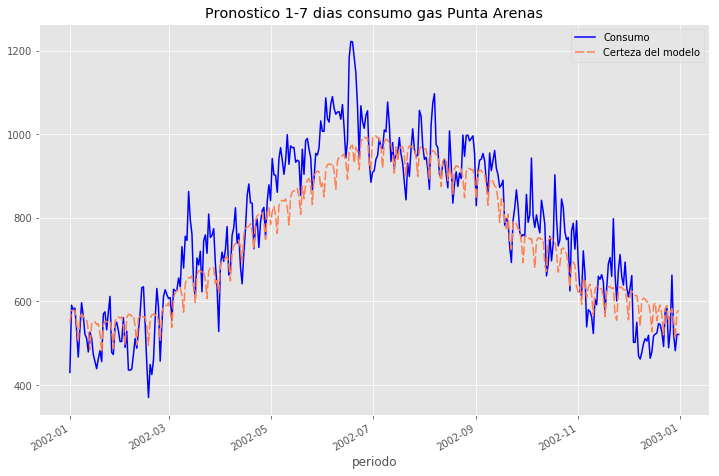

In [38]:
fig , g= plt.subplots(figsize=(12, 8))

g = timeseries[-365:].plot(x='date',y='Consumo',color='blue', ax=g)
g = accuracy_days[-365:].plot(x='periodo',y='prediccion_consumo',color='coral',dashes=[6,2], label='Certeza del modelo' ,ax=g)
#g = forecast_days.plot(x='periodo',y='prediccion_consumo',color='limegreen',dashes=[6,2], label='Predicción consumo', ax=g)

g.set_title('Pronostico 1-7 dias consumo gas Punta Arenas')
plt.show()

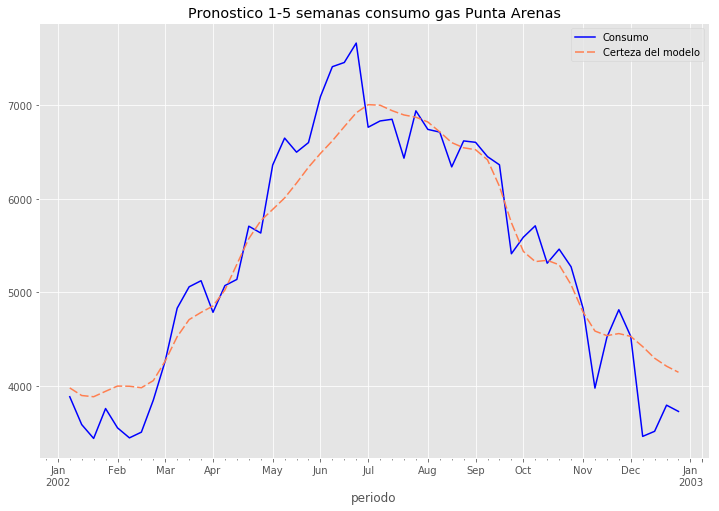

In [39]:
fig , g= plt.subplots(figsize=(12, 8))
#55
g = consum_week[-52:].plot(x='periodo',y='Consumo',color='blue', ax=g)
g = accuracy_weeks.plot(x='periodo',y='prediccion_consumo',color='coral',dashes=[6,2], label='Certeza del modelo' ,ax=g)
#g = forecast_weeks.plot(x='periodo',y='prediccion_consumo',color='limegreen',dashes=[6,2], label='Predicción consumo', ax=g)

g.set_title('Pronostico 1-5 semanas consumo gas Punta Arenas')
plt.show()

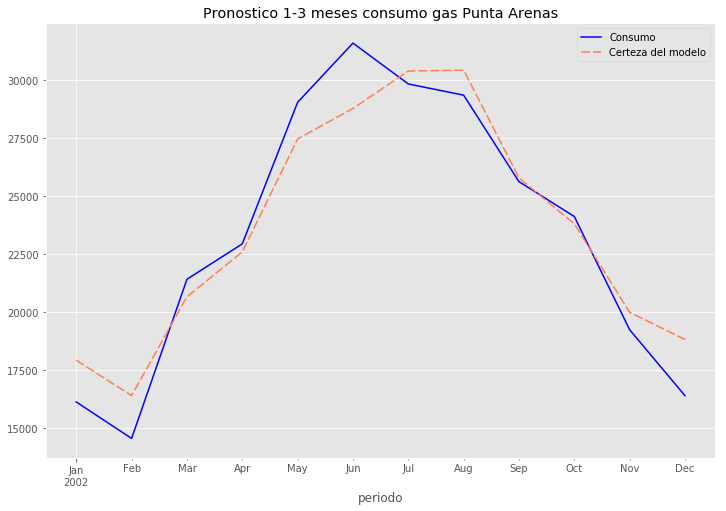

In [40]:
fig , g= plt.subplots(figsize=(12, 8))

g = consum_month[-12:].plot(x='periodo',y='Consumo',color='blue', ax=g)
g = accuracy_months.plot(x='periodo',y='prediccion_consumo',color='coral',dashes=[6,2], label='Certeza del modelo' ,ax=g)
#g = forecast_months.plot(x='periodo',y='prediccion_consumo',color='limegreen',dashes=[6,2], label='Predicción consumo', ax=g)

g.set_title('Pronostico 1-3 meses consumo gas Punta Arenas')
plt.show()

In [41]:
# Error medio cuadratico

RMSE_days = pd.concat([accuracy_days[-365:].prediccion_consumo,  timeseries.sort_values('date')[-365:].Consumo.reset_index(drop=True)], axis=1)
RMSE_days['delta'] = (RMSE_days.prediccion_consumo - RMSE_days.Consumo)**2

In [42]:
#Ceff - criterio de evaluacion cualitativa de la bondad de ajuste

(1-(math.sqrt(RMSE_days.delta.sum() / RMSE_days.shape[0]) / RMSE_days.Consumo.std())**2)*100

84.70674238084274

In [43]:
(math.sqrt(RMSE_days.delta.sum() / RMSE_days.shape[0]) / RMSE_days.Consumo.std())*100

39.10659486475045

In [44]:
# Error medio cuadratico

RMSE_weeks = pd.concat([accuracy_weeks.prediccion_consumo,  consum_week.sort_values('periodo')[-52:].Consumo.reset_index(drop=True)], axis=1)
RMSE_weeks['delta'] = (RMSE_weeks.prediccion_consumo - RMSE_weeks.Consumo)**2

In [45]:
#Ceff - criterio de evaluacion cualitativa de la bondad de ajuste

(1-(math.sqrt(RMSE_weeks.delta.sum() / RMSE_weeks.shape[0]) / RMSE_weeks.Consumo.std())**2)*100

91.40809217824611

In [46]:
(math.sqrt(RMSE_weeks.delta.sum() / RMSE_weeks.shape[0]) / RMSE_weeks.Consumo.std())*100

29.311956300721192

In [47]:
# Error medio cuadratico

RMSE_months = pd.concat([accuracy_months.prediccion_consumo,  consum_month.sort_values('periodo')[-12:].Consumo.reset_index(drop=True)], axis=1)
RMSE_months['delta'] = (RMSE_months.prediccion_consumo - RMSE_months.Consumo)**2

In [48]:
#Ceff - criterio de evaluacion cualitativa de la bondad de ajuste

(1-(math.sqrt(RMSE_months.delta.sum() / RMSE_months.shape[0]) / RMSE_months.Consumo.std())**2)*100

93.82720555540847

In [49]:
(math.sqrt(RMSE_months.delta.sum() / RMSE_months.shape[0]) / RMSE_months.Consumo.std())*100

24.845109065149078

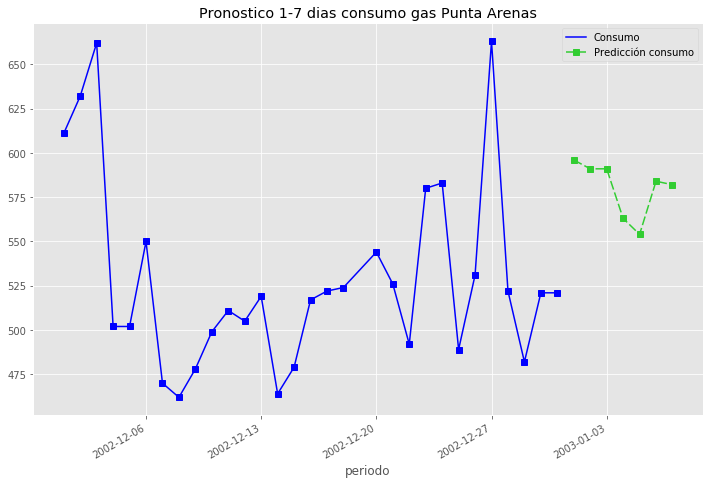

In [50]:
fig , g= plt.subplots(figsize=(12, 8))

g = timeseries[-30:].plot(x='date',y='Consumo',color='blue', marker='s', ax=g)
#g = accuracy_days[-21:].plot(x='periodo',y='prediccion_consumo',color='coral',dashes=[6,2], label='Certeza del modelo', marker='s' ,ax=g)
g = forecast_days.plot(x='periodo',y='prediccion_consumo',color='limegreen',dashes=[6,2], label='Predicción consumo',marker='s', ax=g)

g.set_title('Pronostico 1-7 dias consumo gas Punta Arenas')
plt.show()

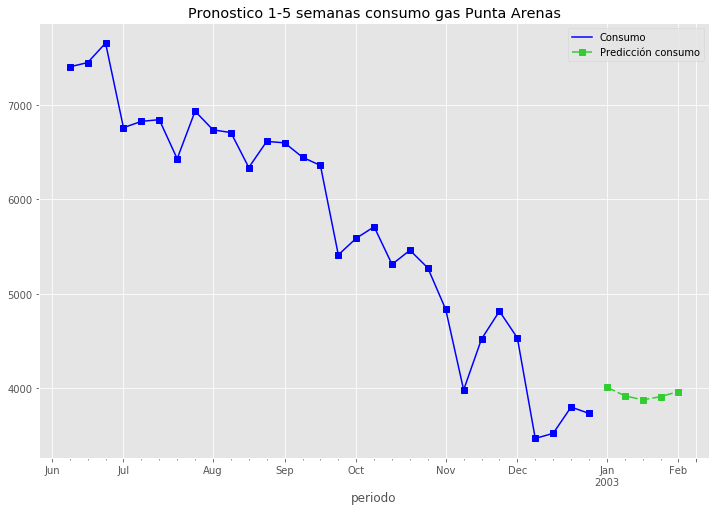

In [51]:
fig , g= plt.subplots(figsize=(12, 8))
#55
g = consum_week[-30:].plot(x='periodo',y='Consumo',color='blue', marker='s', ax=g)
#g = accuracy_weeks.plot(x='periodo',y='prediccion_consumo',color='coral',dashes=[6,2], label='Certeza del modelo', marker='s' ,ax=g)
g = forecast_weeks.plot(x='periodo',y='prediccion_consumo',color='limegreen',dashes=[6,2], label='Predicción consumo', marker='s', ax=g)

g.set_title('Pronostico 1-5 semanas consumo gas Punta Arenas')
plt.show()

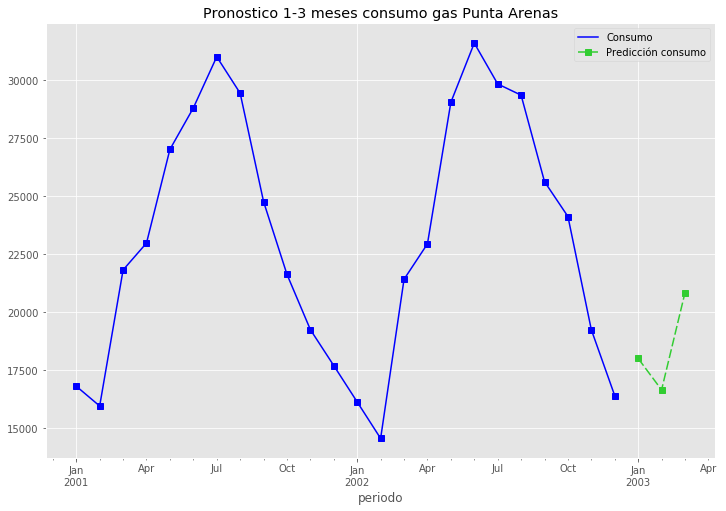

In [52]:
fig , g= plt.subplots(figsize=(12, 8))

g = consum_month[-24:].plot(x='periodo',y='Consumo',color='blue', marker='s', ax=g)
#g = accuracy_months.plot(x='periodo',y='prediccion_consumo',color='coral',dashes=[6,2], label='Certeza del modelo', marker='s' ,ax=g)
g = forecast_months.plot(x='periodo',y='prediccion_consumo',color='limegreen',dashes=[6,2], label='Predicción consumo', marker='s', ax=g)

g.set_title('Pronostico 1-3 meses consumo gas Punta Arenas')
plt.show()